### Segment Anything

In [ ]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator, sam_model_registry
import matplotlib.pyplot as plt
from utils import *
from imagenet_utils import *

In [2]:
# directories and necessary arguments

dir_sims = '/mnt/qb/work/bethge/pmayilvahanan31/sys_gen/utils/sims/'
dataset_base = 'laion400m'
model_embedding = 'ViT-B-16-plus-240__laion400m_e32'
chkpt_path = '/mnt/qb/work/bethge/pmayilvahanan31/sys_gen/utils/sam_checkpoints/sam_vit_h_4b8939.pth'
model_type = 'vit_h'

In [7]:
# get image 

img = load_img(1, 'imagenet-val')
img = (img * 255).astype(np.uint8)

In [9]:
# masks with prompt

input_prompt = "tench"
sam = sam_model_registry[model_type](checkpoint=chkpt_path)
predictor = SamPredictor(sam)
predictor.set_image(img)
masks, _, _ = predictor.predict(input_prompt)

AssertionError: point_labels must be supplied if point_coords is supplied.

### Sketch extraction

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from imagenet_utils import *
from data import *

In [246]:
import faiss

0.0 0.0 0.0


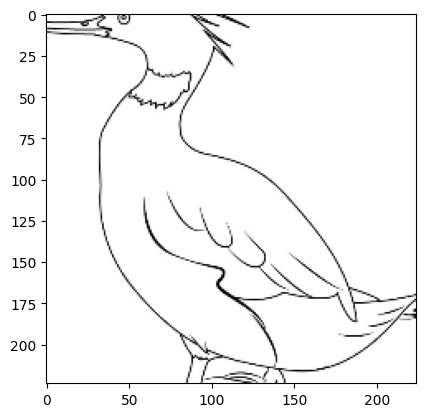

In [247]:
# checking single images

img = load_img(5000, 'imagenet-sketch')

#img = load_img(50, 'imagenet-val')
print(np.sum(img[:, :, 0] - img[:, :, 1]), np.sum(img[:, :, 1] - img[:, :, 2]), np.sum(img[:, :, 0] - img[:, :, 2]))
dim = 0
plt.imshow(img)

(array([5.19000e+02, 2.13000e+02, 2.13000e+02, 2.13000e+02, 1.56000e+02,
        1.38000e+02, 2.04000e+02, 1.29000e+02, 1.17000e+02, 1.26000e+02,
        1.02000e+02, 9.90000e+01, 8.70000e+01, 1.05000e+02, 6.00000e+01,
        7.80000e+01, 9.60000e+01, 1.05000e+02, 1.17000e+02, 8.70000e+01,
        5.40000e+01, 6.30000e+01, 8.40000e+01, 5.10000e+01, 9.60000e+01,
        7.50000e+01, 8.10000e+01, 7.50000e+01, 6.60000e+01, 9.90000e+01,
        8.40000e+01, 3.30000e+01, 5.10000e+01, 8.10000e+01, 4.20000e+01,
        6.60000e+01, 6.60000e+01, 5.10000e+01, 6.00000e+01, 4.20000e+01,
        4.20000e+01, 5.10000e+01, 4.20000e+01, 8.10000e+01, 3.90000e+01,
        6.00000e+01, 7.50000e+01, 6.00000e+01, 3.00000e+01, 3.60000e+01,
        3.60000e+01, 5.40000e+01, 1.02000e+02, 8.10000e+01, 4.80000e+01,
        3.60000e+01, 6.00000e+01, 6.00000e+01, 8.40000e+01, 5.70000e+01,
        7.20000e+01, 7.20000e+01, 8.10000e+01, 7.20000e+01, 1.05000e+02,
        7.80000e+01, 3.90000e+01, 6.30000e+01, 8.10

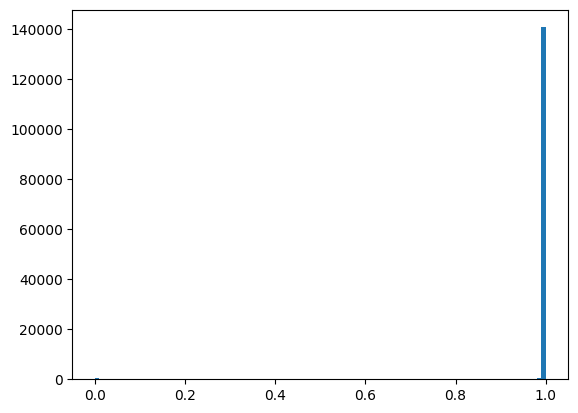

In [248]:
plt.hist(img.reshape(-1), bins=100)

In [249]:
# checking the whole dataset
dataset_name = 'imagenet-val'
batch_size = 250
num_workers = 8
transform_standard = transforms.Compose([
    transforms.ToTensor(),           # Convert the PIL Image to a PyTorch Tensor
    transforms.Resize(255),   # Resize the image to the specified size
    transforms.CenterCrop(224) # Center crop the image to the specified size
])


dataloader = get_dataset(dataset_name, batch_size, num_workers, transform_standard)

In [250]:
i, (images, _) = next(enumerate(dataloader))

In [41]:
device = torch.device("cuda:0")
images = images.to(device)

In [17]:
def count_images_outside_range(images, range_pixel):
    """
    Count the number of images in a batch where at least one pixel value in any channel is outside the specified range.

    Args:
    - images (torch.Tensor): Input batch of images with dimensions [batch_size, 3, height, width].
    - range_pixel (list/tuple): Lower bound and upper bound for the pixel values.
    Returns:
    - int: Number of images in the batch where at least one pixel value is outside the specified range.
    """
    
    # Reshape images and get bounds
    images_reshaped = images.reshape(images.shape[0], np.array(images.shape[1:]).prod())
    lower_bound, upper_bound = range_pixel
    
    # Create masks for pixels outside the specified range
    below_lower_bound_mask = (images_reshaped > lower_bound)
    above_upper_bound_mask = (images_reshaped < upper_bound)

    # Check if at least one pixel is outside the specified range for each image
    # any_pixel_outside_range = (below_lower_bound_mask | above_upper_bound_mask).any(dim=1)
    idcs = torch.where((below_lower_bound_mask & above_upper_bound_mask) == True)[0]

    # Count the number of images satisfying the condition
    #num_images_outside_range = any_pixel_outside_range.sum().item()

    return idcs.unique()

# Example usage:
# Assuming 'batch_of_images' is your input batch tensor and 'lower_bound' and 'upper_bound' are your range bounds
range_pixel = (0.2, 0.8)
idcs = count_images_outside_range(images, range_pixel)


### Fourier amplitude swap

In [269]:
import scipy.misc
import numpy as np
from PIL import Image

im_src = Image.open("source.png").convert('RGB')
im_trg = Image.open("target.png").convert('RGB')

im_src = im_src.resize( (1024,512), Image.BICUBIC )
im_trg = im_trg.resize( (1024,512), Image.BICUBIC )

im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

im_src = im_src.transpose((2, 0, 1))
im_trg = im_trg.transpose((2, 0, 1))

In [271]:
im_src.shape

(3, 512, 1024)

In [280]:
im_src.dtype

dtype('float32')

In [281]:
im_src

array([[[201., 201., 201., ..., 211., 195., 103.],
        [202., 202., 202., ..., 211., 202., 107.],
        [202., 202., 202., ..., 210., 211., 127.],
        ...,
        [177., 179., 180., ..., 238., 238., 238.],
        [173., 174., 173., ..., 239., 239., 239.],
        [170., 172., 179., ..., 239., 239., 239.]],

       [[211., 211., 211., ..., 217., 201., 105.],
        [211., 211., 211., ..., 217., 209., 111.],
        [211., 211., 211., ..., 217., 218., 132.],
        ...,
        [162., 164., 165., ..., 231., 231., 231.],
        [158., 158., 158., ..., 231., 231., 231.],
        [156., 156., 164., ..., 231., 231., 231.]],

       [[218., 218., 218., ..., 222., 207., 104.],
        [218., 218., 218., ..., 222., 214., 112.],
        [218., 218., 218., ..., 221., 223., 136.],
        ...,
        [126., 128., 130., ..., 209., 209., 209.],
        [125., 125., 125., ..., 209., 209., 209.],
        [124., 125., 131., ..., 209., 209., 209.]]], dtype=float32)

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from imagenet_utils import *
from data import *

1172.7411 189.66666 1362.4078


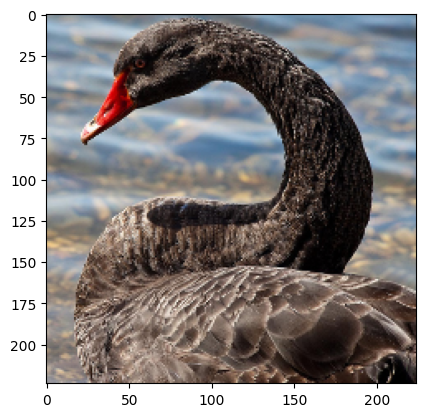

In [283]:
# checking single images

img_val = load_img(5000, 'imagenet-val')

#img = load_img(50, 'imagenet-val')
img = img_val
print(np.sum(img[:, :, 0] - img[:, :, 1]), np.sum(img[:, :, 1] - img[:, :, 2]), np.sum(img[:, :, 0] - img[:, :, 2]))
dim = 0
plt.imshow(img_val)

0.0 0.0 0.0


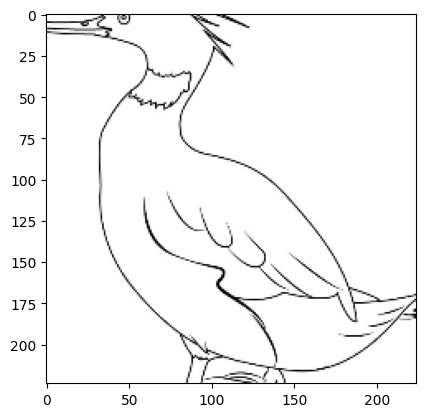

In [284]:
# checking single images

img_sketch = load_img(5000, 'imagenet-sketch')
img = img_sketch
#img = load_img(50, 'imagenet-val')
print(np.sum(img[:, :, 0] - img[:, :, 1]), np.sum(img[:, :, 1] - img[:, :, 2]), np.sum(img[:, :, 0] - img[:, :, 2]))
dim = 0
plt.imshow(img_sketch)

In [285]:
# convert both images to 255.0

In [286]:
img_sketch*=255.0
img_val*=255.0

In [287]:
def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(0, 1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(0, 1) )

    h,w,_ = a_src.shape
    b = (np.floor(np.amin((h,w))*L)).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[h1:h2,w1:w2, :] = a_trg[h1:h2,w1:w2, :]
    a_src = np.fft.ifftshift(a_src, axes=(0, 1) )
    return a_src

In [288]:
# get fft of both source and target
fft_src_np = np.fft.fft2( img_sketch, axes=(0, 1) )
fft_trg_np = np.fft.fft2( img_val, axes=(0, 1) )

fft_src_np = np.fft.fft2( img_val, axes=(0, 1) )
fft_trg_np = np.fft.fft2( img_sketch, axes=(0, 1) )

# extract amplitude and phase of both ffts
amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

In [289]:
amp_src[:3, :3, :]

array([[[5583291.69899596, 5284242.68028272, 5235877.68221169],
        [ 764984.35443091,  749818.05320383,  759385.20198364],
        [ 403773.55448548,  491433.97800655,  534388.77019528]],

       [[  24239.45614177,  249055.44292162,  482846.68802354],
        [  45605.43248749,  102721.70742508,  131357.63718666],
        [ 192481.97913164,  177261.19326138,  195316.66250738]],

       [[ 185716.1939413 ,  142551.23059915,  135320.65501512],
        [ 534260.91881194,  671494.4540544 ,  724520.51492817],
        [ 161512.80509728,  224845.08597207,  236072.09147516]]])

In [290]:
amp_trg[:3, :3, :]

array([[[12375736.8972402 , 12375736.8972402 , 12375736.8972402 ],
        [  125468.17256982,   125468.17256982,   125468.17256982],
        [   35133.36888132,    35133.36888132,    35133.36888132]],

       [[  136030.75866177,   136030.75866177,   136030.75866177],
        [  114955.56405202,   114955.56405202,   114955.56405202],
        [   57759.64495746,    57759.64495746,    57759.64495746]],

       [[   18618.46774595,    18618.46774595,    18618.46774595],
        [   71098.52940789,    71098.52940789,    71098.52940789],
        [   38360.60276034,    38360.60276034,    38360.60276034]]])

In [291]:
# mutate the amplitude part of source with target
L = 0.01
amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

# mutated fft of source
fft_src_ = amp_src_ * np.exp( 1j * pha_src )

# get the mutated image
src_in_trg = np.fft.ifft2(fft_src_, axes=(0, 1))
src_in_trg = np.real(src_in_trg)

In [296]:
src_in_trg.max()

411.93263880857756

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


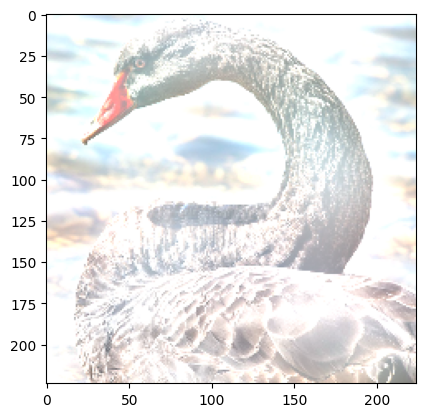

In [298]:
plt.imshow(src_in_trg.astype(int))

(array([1.000e+00, 5.000e+00, 5.000e+00, 1.500e+01, 1.100e+01, 8.000e+00,
        1.700e+01, 1.900e+01, 2.100e+01, 2.200e+01, 4.600e+01, 5.300e+01,
        8.200e+01, 9.600e+01, 1.630e+02, 2.920e+02, 4.380e+02, 5.850e+02,
        8.050e+02, 1.018e+03, 1.313e+03, 1.335e+03, 1.543e+03, 1.826e+03,
        1.856e+03, 1.976e+03, 2.110e+03, 2.347e+03, 2.393e+03, 2.520e+03,
        2.575e+03, 2.875e+03, 2.943e+03, 3.078e+03, 3.103e+03, 3.234e+03,
        3.222e+03, 3.239e+03, 3.365e+03, 3.405e+03, 3.451e+03, 3.535e+03,
        3.640e+03, 3.735e+03, 3.764e+03, 3.819e+03, 3.810e+03, 3.763e+03,
        3.851e+03, 3.737e+03, 3.892e+03, 3.754e+03, 3.559e+03, 3.392e+03,
        3.398e+03, 3.275e+03, 3.073e+03, 2.948e+03, 2.859e+03, 2.635e+03,
        2.538e+03, 2.510e+03, 2.332e+03, 2.144e+03, 1.962e+03, 1.770e+03,
        1.596e+03, 1.420e+03, 1.331e+03, 1.250e+03, 1.064e+03, 9.040e+02,
        8.070e+02, 7.870e+02, 6.350e+02, 5.640e+02, 5.470e+02, 4.280e+02,
        3.750e+02, 2.910e+02, 2.890e+0

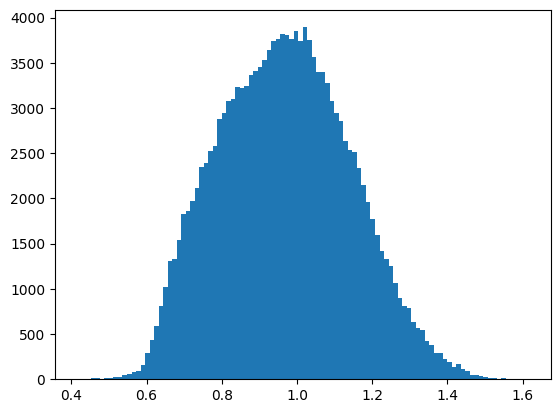

In [303]:
plt.hist((src_in_trg/255).reshape(-1),bins=100)

(array([1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 1.000e+00,
        7.000e+00, 8.000e+00, 5.000e+00, 6.000e+00, 3.000e+00, 5.000e+00,
        1.200e+01, 5.000e+00, 1.100e+01, 8.000e+00, 6.000e+00, 1.500e+01,
        1.200e+01, 1.000e+01, 2.400e+01, 2.200e+01, 2.700e+01, 2.600e+01,
        3.700e+01, 4.500e+01, 4.600e+01, 5.000e+01, 7.900e+01, 8.400e+01,
        1.320e+02, 1.600e+02, 2.040e+02, 2.340e+02, 2.990e+02, 2.860e+02,
        3.900e+02, 4.150e+02, 4.480e+02, 5.700e+02, 6.370e+02, 6.760e+02,
        6.610e+02, 6.740e+02, 7.450e+02, 7.980e+02, 8.650e+02, 9.610e+02,
        9.170e+02, 9.390e+02, 9.630e+02, 1.013e+03, 1.078e+03, 1.032e+03,
        1.164e+03, 1.183e+03, 1.174e+03, 1.219e+03, 1.221e+03, 1.299e+03,
        1.296e+03, 1.279e+03, 1.375e+03, 1.500e+03, 1.433e+03, 1.510e+03,
        1.527e+03, 1.551e+03, 1.540e+03, 1.563e+03, 1.615e+03, 1.619e+03,
        1.532e+03, 1.690e+03, 1.590e+03, 1.649e+03, 1.666e+03, 1.699e+03,
        1.703e+03, 1.702e+03, 1.816e+0

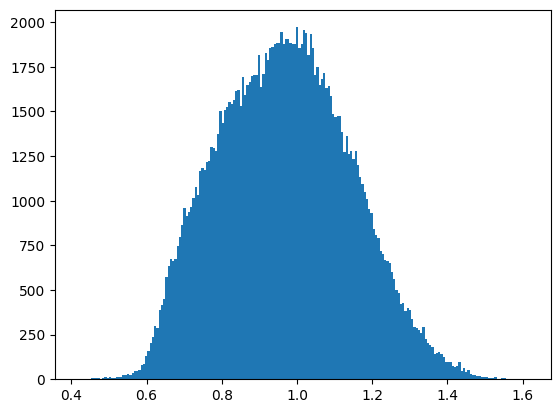

In [266]:
plt.hist(src_in_trg.reshape(-1),bins=200)

In [96]:
import scipy.misc

In [97]:
scipy.misc.toimage(src_in_trg, cmin=0.0, cmax=255.0)

AttributeError: module 'scipy.misc' has no attribute 'toimage'

### Compute mean, variance, skewness, kurtosis

In [42]:
# reshape images

with torch.no_grad():
    images_reshaped = images.reshape(images.shape[0], np.array(images.shape[1:]).prod())

In [43]:
mean = torch.mean(images_reshaped, dim = -1)
diffs = images_reshaped - mean.unsqueeze(dim=-1)
var = torch.mean(torch.pow(diffs, 2.0), dim = -1)
std = torch.pow(var, 0.5)
zscores = diffs / std.unsqueeze(-1)
skews = torch.mean(torch.pow(zscores, 3.0), dim = -1)
kurtoses = torch.mean(torch.pow(zscores, 4.0), dim = -1) - 3.0 

(array([ 2., 11., 15., 17., 27., 26., 30., 14., 13., 12., 13.,  8.,  6.,
         5.,  9.,  4.,  1.,  4.,  2.,  1.,  3.,  3.,  2.,  1.,  1.,  2.,
         0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,
         1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.7395186 , -1.5894337 , -1.4393487 , -1.2892637 , -1.1391788 ,
        -0.9890937 , -0.83900875, -0.6889237 , -0.53883874, -0.38875377,
        -0.23866877, -0.08858379,  0.0615012 ,  0.21158618,  0.36167118,
         0.5117562 ,  0.66184115,  0.8119261 ,  0.9620111 ,  1.1120961 ,
         1.262181  ,  1.4122661 ,  1.5623511 ,  1.7124361 ,  1.862521  ,
         2.0126061 ,  2.162691  ,  2.312776  ,  2.462861  ,  2.612946

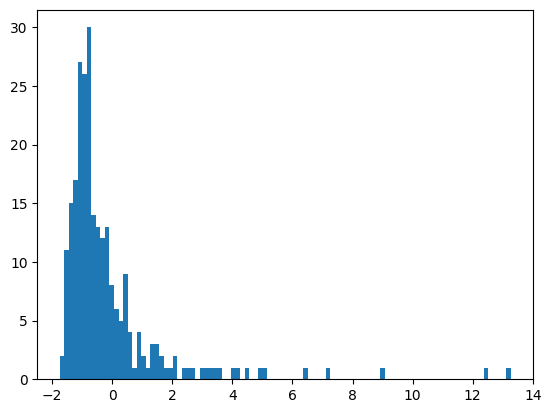

In [44]:
plt.hist(kurtoses.cpu().numpy(), bins=100)

### Median filter on images

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple


class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).mode(dim=-1)[0]
        return x

In [9]:
kernel_sizes = [5, 10, 25, 50, 100, 125, 150, 200]
stride_ratios = [1, 2, 3, 4, 5, 10, 25, 50]

In [10]:
perc = {}

for ks in kernel_sizes:
    perc[ks] = {}
    for sr in stride_ratios:
        m = MedianPool2d(ks,stride = (ks//sr) if (ks//sr)!=0 else 1, padding=0)
        
        with torch.no_grad():
            images_med = m(images).cpu()
            range_pixel = (0.2, 0.8)
            idcs = count_images_outside_range(images_med, range_pixel)
            perc[ks][sr] = idcs
        

RuntimeError: CUDA out of memory. Tried to allocate 12.92 GiB (GPU 0; 10.76 GiB total capacity; 288.00 MiB already allocated; 9.96 GiB free; 288.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
ks

10

In [12]:
sr

10